# Preprocessing Pipeline

### Imports

In [2]:
import os.path
import pyxdf
import pandas as pd
import mne
from os import path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tkinter import Tk
from tkinter.filedialog import askdirectory
import glob, os
from autoreject import get_rejection_threshold
import promptlib
import autoreject  
import math


### Constants

In [3]:
TIME_OFFSET = -1  # in sec, the event window begins x seconds before the time stamp
DUR = 5 # in sec, duration of the event window in seconds
EVENTS = {
    'Baseline' : None,
    'MI' : 'MI trial marker',
    'PO' : 'Unity.Marker.TargetID'
}
EPOCH_VAR = {
    'TIME_OFFSET' : TIME_OFFSET,
    'DUR' : DUR,
    'EVENTS' : EVENTS
}
MONTAGE = 'DATA/montage_perfect.csv'
ICA_RECAP = 'DATA/ica_recap.csv'

In [4]:
montage_label = pd.read_csv(MONTAGE)
channel_label = montage_label['ch_name'].tolist()
montage_label.head()


ch_name      x      y       z
0     FP1 -0.309  0.951  0.0000
1     FPZ  0.000  1.000 -0.0001
2     FP2  0.309  0.951  0.0000
3      F7 -0.809  0.588  0.0000
4      F3 -0.534  0.659  0.5300

### Functions

In [9]:
def select_stream(stream_data, selection='type',desired_type='EEG'):
    
    for stream in stream_data:
        stream_type = stream['info'][selection][0]
        
        if stream_type == desired_type and len(stream['time_series'])>0:
            return stream
        else:
            continue

def show_epoch(epochs,n_epochs=10):
    if epochs != None:
        print(epochs)
        print(epochs.events)
        epochs.plot(n_epochs=n_epochs,events=epochs.events, event_id=epochs.event_id)


        
def select_eegs(xdf_files):
    
    eeg_files = []

    for file in xdf_files:
        print('Processing {}'.format(file))
        data,header = pyxdf.load_xdf(file);
        eeg_file = select_stream(data);
        eeg_file['file'] = os.path.basename(os.path.normpath(file));
        eeg_files.append(eeg_file);
    
    return eeg_files

def raw_processing(raw,filtering,bad_chs,fmin=0.1,fmax=40):
    signal = raw.copy()
    
    if isinstance(bad_chs,str):
        bad_chs = bad_chs.split(',') + ['M1','M2','EOG']
    else:
        bad_chs = ['M1','M2','EOG']
    
    if bad_chs.count('CPZ') > 0:
        bad_chs.remove('CPZ')
        
    signal.info['bads'].extend(bad_chs)

    if "BP" in filtering:
        signal = signal.filter(fmin,fmax)

    if filtering == 'rawBPCAR':
        signal, ref_data = mne.set_eeg_reference(signal, ref_channels='average', copy=True)
    
    return signal
    
def to_mne(data_path, filtering, NB_CHANNELS = 64):
    stream,header = pyxdf.load_xdf(data_path)
    stream_eeg = select_stream(stream)

    if stream_eeg is None:
        print("No EEG for " + data_path)
        signal = None;
        eventss = None;
        event_idss = None;
        return signal, eventss, event_idss
    
    ch_names = []
    channels = stream_eeg['info']['desc'][0]['channels'][0]['channel']
    file = os.path.basename(os.path.normpath(data_path))

    for channel in channels:
        current_label = channel['label'][0]
        if (current_label != 'AUX3') & (current_label != 'TRIGGER'):
            ch_names.append(channel['label'][0])
        else:
            continue

    data = stream_eeg["time_series"].copy().T;  # data.shape = (nb_channels, nb_samples)
    data = data[0:64,:] # We do not keep data for AUX3 and TRIGGER
    data *= 1e-6  # convert from uV to V (mne uses V)
    #assert len(data) == NB_CHANNELS      
    sfreq = float(stream_eeg["info"]["nominal_srate"][0])
    ch_types = ['eeg'] * 64;
    info = mne.create_info(ch_names, sfreq, ch_types);
    # info = mne.create_info(NB_CHANNEfLS, sfreq)
    raw = mne.io.RawArray(data, info);

    ### Filtering and CAR
    subject = file.split('_')[0];
    subject_id = subject[-2:]
    bad_chs = get_bad_chs(subject);
    
    signal = raw_processing(raw,filtering,bad_chs);
    

    ### Epoch management
    
    
    event_keys = list(EVENTS.keys());
    event_type = [key for key in event_keys if key in file][0];
    print('Subject: {}, EVENT: {}'.format(subject,event_type))
    if event_type == 'PO':
        
        event_id = {
            'Left':1,
            'Right':2,
            'Third':3
        }
        stream_event = select_stream(stream,'name',EVENTS[event_type]);
        if stream_event is None:
            eventss = None;
            event_idss = None;
        else:
            target_nb = np.array(stream_event['time_series']).squeeze();  # array with target IDs
            t_origin = stream_eeg['time_stamps'][0];
            t_stamps = stream_event['time_stamps'] - t_origin;
            annots = mne.Annotations(onset=t_stamps, duration = 0., description=target_nb);
            raw_annotated = signal.copy().set_annotations(annots);
            signal = raw_annotated
            eventss, event_idss = mne.events_from_annotations(raw_annotated);
        '''
        reject = get_rejection_threshold(epochs)
        epochs = mne.Epochs(raw_annotated, eventss, event_id, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=reject), proj=False)
        '''
        
    elif event_type == 'MI':
        '''
        t_origin = stream_eeg['time_stamps'][0]
        stream_event = select_stream(stream,'name',EVENTS[event_type])
        time_stamps = stream_event['time_stamps'] - t_origin  # signal begins at 0s
        target_nb = np.array(stream_event['time_series']).squeeze()  # array with target IDs
        TIME_OFFSET = -1
        annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)
        rawannot = rawBPCAR.copy().set_annotations(annots)


        #### Create events from annotations

        events, event_id = mne.events_from_annotations(rawannot)
        # print(event_id)
        # print(events)


        #### Create mne.Epochs with events and event_ID
        # also define the event window 

        epochs = mne.Epochs(rawBPCAR, events, event_id, tmin=TIME_OFFSET, tmax=DUR, baseline=(TIME_OFFSET,0), reject=dict(eeg=400e-6))
        '''
        
        stream_event = select_stream(stream,'name',EVENTS[event_type]);
        if stream_event is None:
            eventss = None;
            event_idss = None;
        else:
            target_nb = np.array(stream_event['time_series']).squeeze();  # array with target IDs
            
            if int(subject_id) > 20:
                target_nb = np.concatenate((target_nb[30:60],target_nb[90:120]))
                target_time = stream_event['time_stamps'][30:60].tolist() + stream_event['time_stamps'][90:120].tolist()
                target_time = np.array(target_time)
            else:
                target_time = stream_event['time_stamps']

            t_origin = stream_eeg['time_stamps'][0];

            n_trial = int(len(target_time)/30);
            t_stamps = np.empty(0)
            for j in range(n_trial):
                ts = [target_time[30*j] - t_origin + 9* i for i in range(30)];
                t_stamps = np.concatenate((t_stamps, ts));
            '''
            ts_1 = [stream_event['time_stamps'][0] - t_origin +2 + 9* i for i in range(30)];
            ts_2 = [stream_event['time_stamps'][30] - t_origin +2 + 9* i for i in range(30)];
            t_stamps = np.concatenate((ts_1, ts_2));
            '''
            t_onset = t_stamps;
            
            annots = mne.Annotations(onset=t_onset, duration = 0., description=target_nb);  
            
            
            
            raw_annotated = signal.copy().set_annotations(annots);
            signal = raw_annotated
            #reject = get_rejection_threshold(signal)
            eventss, event_idss = mne.events_from_annotations(raw_annotated);
            
        '''
        
        epochs = mne.Epochs(raw_annotated, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=reject), proj=False)
        '''
    else:
        eventss = None;
        event_idss = None;
        #epochs = None


    return signal, eventss, event_idss

def get_epochs(EEG_dict,EVENTS_dict):
    ### Epoch management
    
    conditions = list(EEG_dict.keys())
    
    for condition in conditions:
 
        signal = EEG_dict[condition]['signal']
        eventss = EVENTS_dict[condition]['events']
        event_idss = EVENTS_dict[condition]['events_ids']

        if "Baseline" in condition:
            epochs = None
        else:
            epochs = mne.Epochs(signal, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=None, proj=False, reject_by_annotation=None)
            reject = get_rejection_threshold(epochs)
            reject_criteria = dict(eeg=reject)
            epochs = mne.Epochs(signal, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=reject, proj=False, reject_by_annotation=None)
        
        EEG_dict[condition]['epochs'] = epochs

    
    return EEG_dict

def read_file(path,filtering='rawBPCAR'):
    
    initial_directory = os.getcwd()
    xdf_files = []

    for file in glob.glob(path+"\*.xdf"):
        if 'MIpre' in file or 'MIpost' in file:
            xdf_files.append(file)

    EEG_dict = {}
    EVENTS_dict = {}
    for file in xdf_files:
        mne_data,events,events_idss = to_mne(file,filtering)

        if mne_data is None:
            continue
        else:
            file_name = os.path.basename(file).split('.')[0]
            EEG_dict[file_name] = {}
            EEG_dict[file_name]['signal'] = mne_data
            #EEG_dict[file_name]['epochs'] = epochs
            EVENTS_dict[file_name] = {}
            EVENTS_dict[file_name]['events'] = events
            EVENTS_dict[file_name]['events_ids'] = events_idss
    
    return EEG_dict,EVENTS_dict

def save_fif(EEG_dict):
    EEG_keys = list(EEG_dict.keys())
    subject_ID = EEG_keys[0].split('-')[1].split('_')[0]
    
    if int(subject_ID[1:3]) < 11:
        grp = "Group_Realistic_Arm"
    else:
        grp = "Group_Realistic_Arm_Tactile"
    
    path = "Data/" + grp + "/" + subject_ID + "/FIF/" 
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
    for condition in EEG_keys:
        EEG_dict[condition]['signal'].save(path + condition + '-signal.fif' ,overwrite=True)
        
        if EEG_dict[condition]['epochs'] != None:
            EEG_dict[condition]['epochs'].save(path + condition + '-epochs.fif',overwrite=True)
    
def get_montage(csv_file, scale_factor=0.095):
    """
    Get the montage of the EEG data
    :param csv_file: csv file with the montage
    :param scale_factor: scale factor for the montage
    :return: montage
    """
    df_montage = pd.read_csv(csv_file)
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(df_montage['ch_name'], df_montage[['x', 'y', 'z']].values*scale_factor)), coord_frame='head')
    # montage.plot();
    return montage

def interpolate_bad_channels(raw, montage, bad_channels=[]):
    """
    Interpolate bad channels
    :param raw: raw data
    :param bad_channels: list of bad channels
    :return: raw data with interpolated bad channels
    """
    if bad_channels != []:
        raw.info['bads'].extend(bad_channels)
        raw.set_montage(montage)
        print("Interpolating channels: ", raw.info['bads'], "exclude M1, M2, Trigger")
        raw_interp = raw.copy().interpolate_bads(exclude=['M1', 'M2', 'Trigger'])
        raw_interp.plot(scalings=0.00013); 
        # print list of interpolated channels
        return raw_interp
    else:
        print("No bad channels to interpolate")
        return raw

def ica_analysis(signal,n_components=20,random_seed=0):
    ica = mne.preprocessing.ICA(n_components=20,random_state=0)
    signal.set_montage(get_montage(MONTAGE),on_missing='warn')
    ica.fit(signal.copy().filter(0.1,40))
    ica.plot_components()
    ica.plot_sources(signal.copy().filter(0.1,40))
    return ica

def get_bad_chs(subject):
    ch_recap = pd.read_csv("Data\ch_recap_ica.csv")
    bad_chs = ch_recap[ch_recap['group'] == subject]['interpolated_channels'].squeeze()
    if not isinstance(bad_chs,str):
        bad_chs = [];
    
    return bad_chs

def get_ica(EEG_dict):
    conditions = list(EEG_dict.keys())
    ICA_dict ={}
    for condition in conditions:
        ica = mne.preprocessing.ICA(n_components=25,random_state=0);
        signal = EEG_dict[condition]['signal'].copy();
        signal.set_montage(get_montage(MONTAGE),on_missing='warn');
        ica.fit(signal.copy());
        ICA_dict[condition] = ica.copy();

    return ICA_dict

def apply_ica(EEG_dict,ICA_dict):
    ica_recap = pd.read_csv(ICA_RECAP)
    EEG_keys = list(EEG_dict.copy().keys())

    EEG_dict_2 = EEG_dict.copy()
    EEG_dict_corrected = EEG_dict.copy()
    for condition in EEG_keys:
        bad_comp = ica_recap[ica_recap['condition'] == condition]['bad_components'].copy().squeeze()
        if bad_comp != "None":
            bad_comp = [int(x) for x in bad_comp.split(',')];
            ica = ICA_dict[condition].copy()
            signal = EEG_dict[condition]['signal'].copy()
            eeg_corrected = ica.apply(signal.copy(),exclude=bad_comp)
            EEG_dict_corrected[condition]['signal'] = eeg_corrected.copy()

    return EEG_dict_2,EEG_dict_corrected.copy()
    
def save_ica_imgs(ICA_dict,EEG_dict):
    conditions = list(ICA_dict.keys())
    subject_ID = conditions[0].split('-')[1].split('_')[0]
    
    if (int(subject_ID[1:3]) < 11) | ((int(subject_ID[1:3]) > 20) & (int(subject_ID[1:3]) <= 25)):
        grp = "Group_Realistic_Arm"
    else:
        grp = "Group_Realistic_Arm_Tactile"
        
    path = "Data/" + grp + "/" + subject_ID + "/" + "ICA_data/"
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
        
    for condition in conditions:
        print('Subject ' + subject_ID + ': ' + condition)
        ica_comp = ICA_dict[condition].plot_components()
        ica_sources = ICA_dict[condition].plot_sources(EEG_dict[condition]['signal'].copy())
        ICA_dict[condition].save(path+condition+"_ica",overwrite=True)
        ica_comp[0].savefig(path+condition+'_ica_comp.png')
        ica_comp[1].savefig(path+condition+'_ica_comp_2.png')
        ica_sources.savefig(path+condition+'_ica_sources.png')
        
def process_all(folder_idxs,filtering="rawBP"):
    for idx in folder_idxs:
        if (idx < 11) | ((idx > 20)&(idx <= 25)):
            path = 'Data/Group_Realistic_Arm/S'
            if idx < 10:
                path = path+'0'+str(idx)
            else:
                path = path+str(idx)
        else:
            path = 'Data/Group_Realistic_Arm_Tactile/S'+str(idx)
        print("Processing: " + path)
     
        EEG_dict,EVENTS_dict = read_file(path,filtering);
        ICA_dict = get_ica(EEG_dict.copy())
        save_ica_imgs(ICA_dict,EEG_dict)

def ica_correction(folder_idxs):
    for idx in folder_idxs:
        if idx < 11:
            path = 'Data/Group_Realistic_Arm/S'
            if idx < 10:
                path = path+'0'+str(idx)
            else:
                path = path+str(idx)
        else:
            path = 'Data/Group_Realistic_Arm_Tactile/S'+str(idx)
        print("Processing: " + path)

        EEG_dict,EVENTS_dict = read_file(path,'rawBP');
        EEG_dict_corrected = {}
        ICA_dict = {}

        for condition in list(EEG_dict.keys()):
            ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
        
        EEG_dict_2,EEG_dict_corrected = apply_ica(EEG_dict,ICA_dict)
        
        for condition in list(EEG_dict.keys()):
            signal = EEG_dict_corrected[condition]['signal']
            signal, ref_data = mne.set_eeg_reference(signal, ref_channels='average', copy=True)
            EEG_dict_corrected[condition]['signal'] = signal


        EEG_dict_epoched = get_epochs(EEG_dict_corrected,EVENTS_dict)
        #save_fif(EEG_dict_epoched)
        return EEG_dict_epoched

### Subject Selection (Hardcoded)

### EEG streams selection

In [ ]:
EEG_dict,EVENTS_dict = read_file("Data\Group_Realistic_Arm_Tactile\S16",'rawBP');

In [ ]:
EEG_dict['sub-16_MIpost_ses-S001_task-Default_run-001_eeg']['signal'].info

### Computation of ICA for each condition

In [ ]:
ICA_dict = get_ica(EEG_dict.copy())

### Plot and save ICA for each condition 

In [ ]:
save_ica_imgs(ICA_dict)

### Apply ICA to correct signal

In [ ]:
EEG_dict_corrected = apply_ica(EEG_dict.copy(),ICA_dict.copy())

### Epoch corrected eegs

In [ ]:
EEG_dict_epoched = get_epochs(EEG_dict_corrected,EVENTS_dict)

In [ ]:
EEG_dict_epoched['sub-S07_MIpost_ses-S001_task-Default_run-001_eeg']['epochs'].plot()

### Saving signals

In [ ]:
save_fif(EEG_dict_epoched)

In [ ]:
EEG_dict['sub-S02_MIpost']['signal'].save('Data/Group_Realistic_Arm/S01/test/data.fif')

### Process every subject for ICA decomposition

Processing: Data/Group_Realistic_Arm_Tactile/S28


Stream 1: Calculated effective sampling rate 947.3122 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=315133
    Range : 0 ... 315132 =      0.000 ...   615.492 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16897 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.3s finished


Subject: sub-S28, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']


Stream 1: Calculated effective sampling rate 946.4945 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=323064
    Range : 0 ... 323063 =      0.000 ...   630.982 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16897 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.2s finished


Subject: sub-S28, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Fitting ICA to data using 61 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:320: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components
Fitting ICA took 16.5s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:320: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components
Fitting ICA took 15.7s.
Subject S28: sub-S28_MIpost


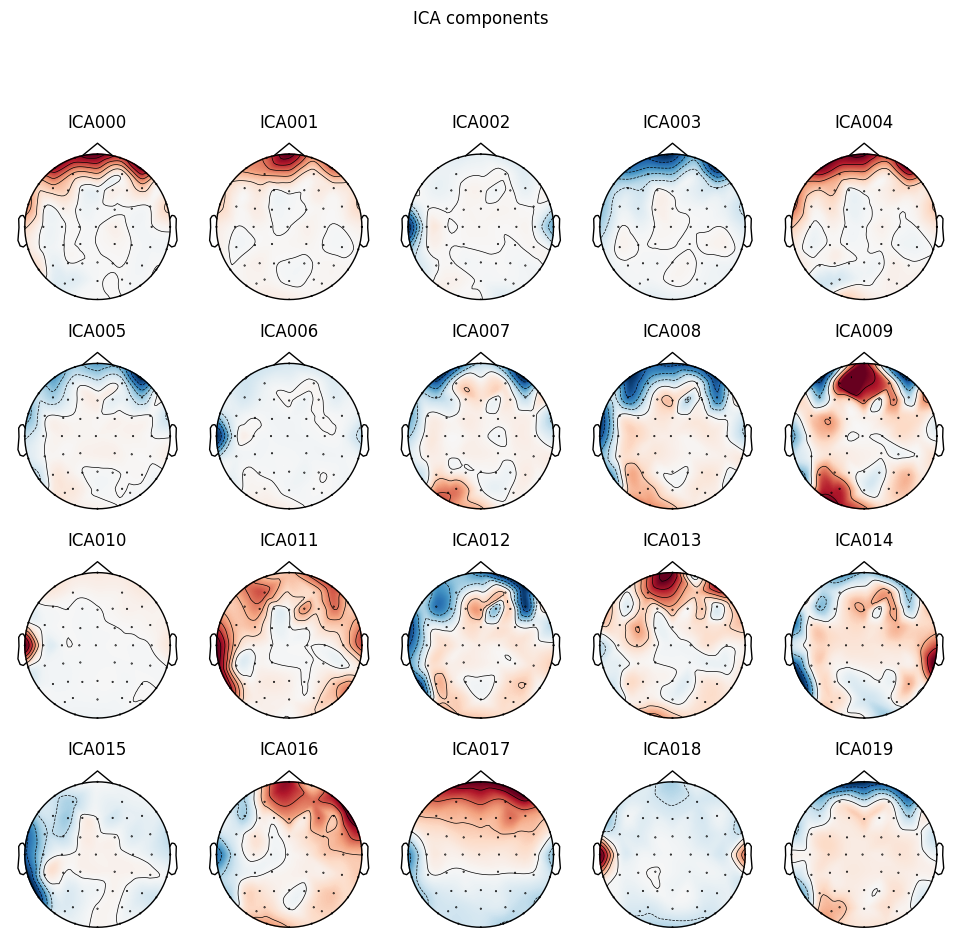

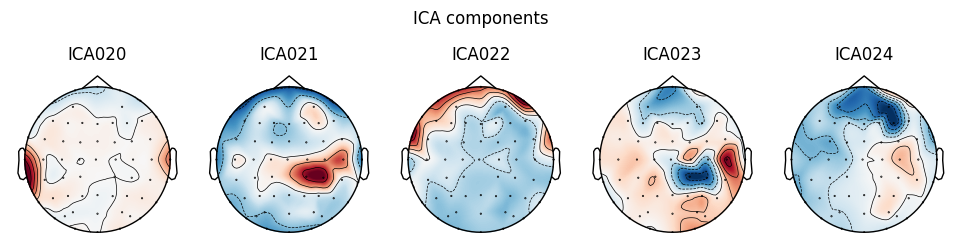

Creating RawArray with float64 data, n_channels=25, n_times=315133
    Range : 0 ... 315132 =      0.000 ...   615.492 secs
Ready.


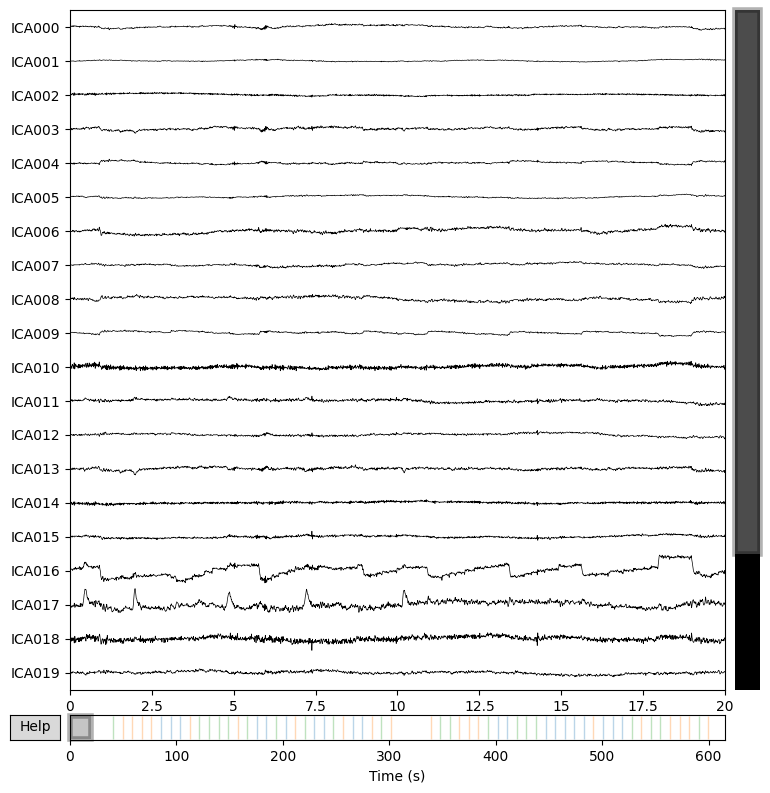

Writing ICA solution to c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm_Tactile\S28\ICA_data\sub-S28_MIpost_ica...


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:362: RuntimeWarning: This filename (Data/Group_Realistic_Arm_Tactile/S28/ICA_data/sub-S28_MIpost_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition].save(path+condition+"_ica",overwrite=True)


Subject S28: sub-S28_MIpre


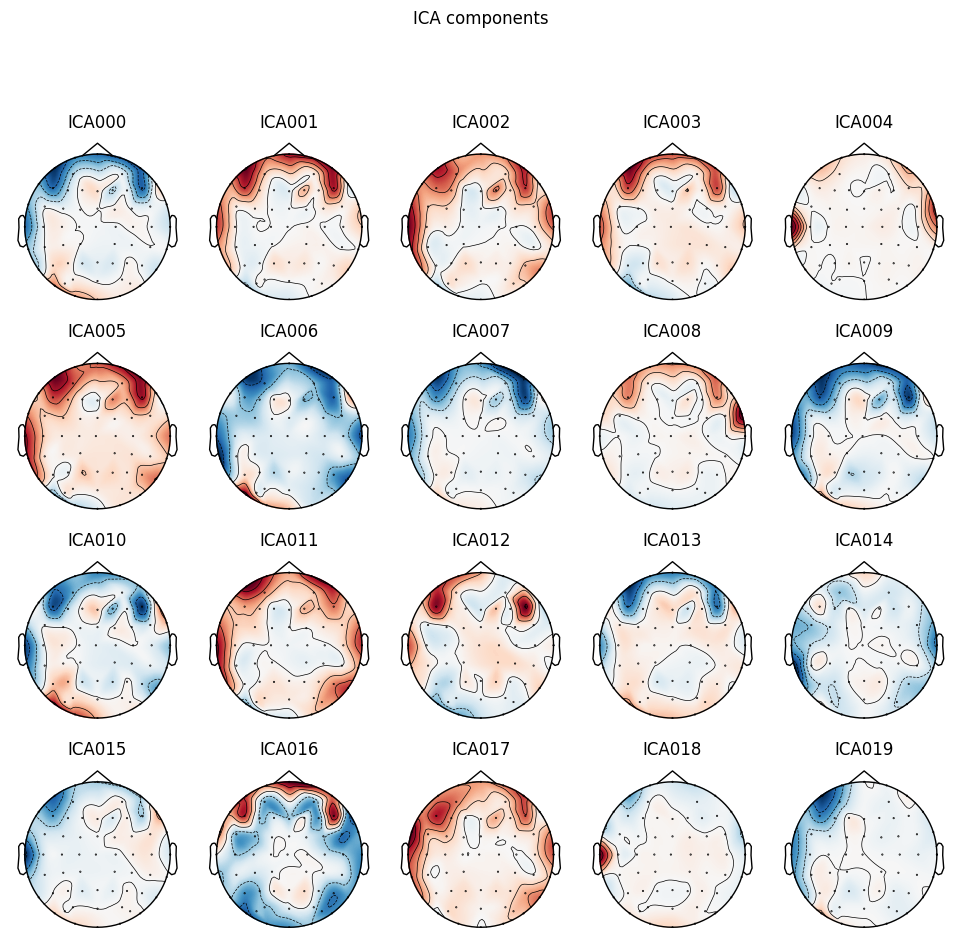

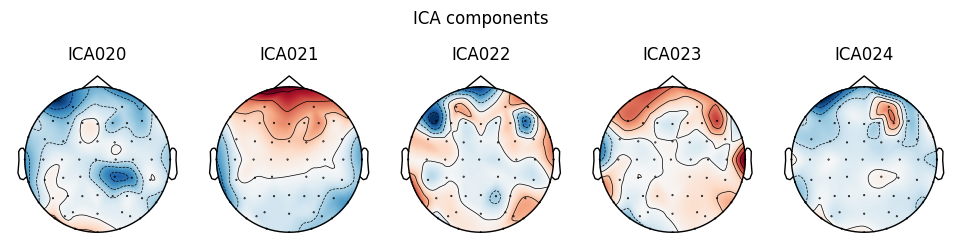

Creating RawArray with float64 data, n_channels=25, n_times=323064
    Range : 0 ... 323063 =      0.000 ...   630.982 secs
Ready.


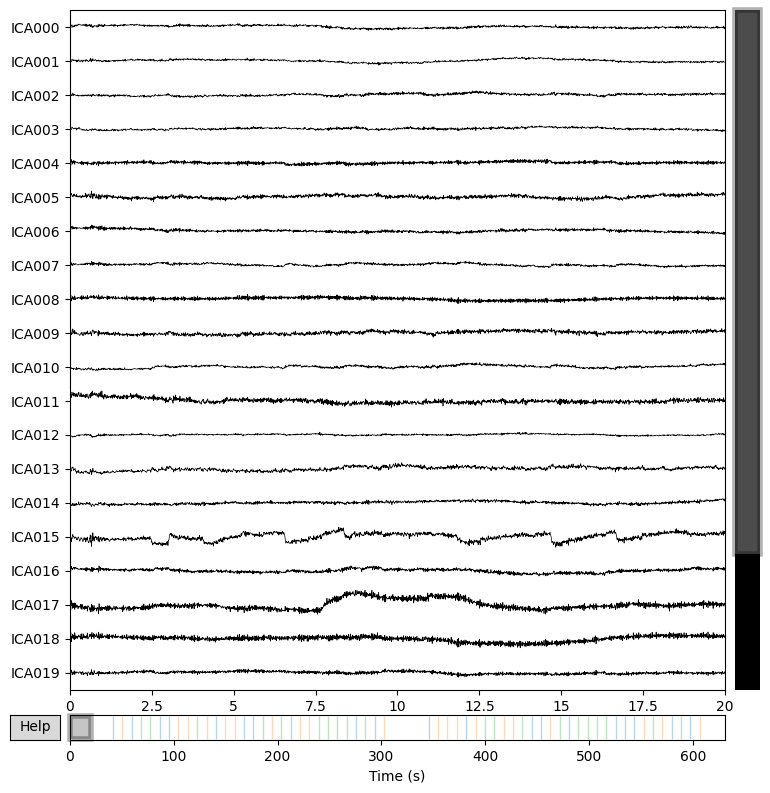

Writing ICA solution to c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm_Tactile\S28\ICA_data\sub-S28_MIpre_ica...


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:362: RuntimeWarning: This filename (Data/Group_Realistic_Arm_Tactile/S28/ICA_data/sub-S28_MIpre_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition].save(path+condition+"_ica",overwrite=True)


Processing: Data/Group_Realistic_Arm_Tactile/S29


Stream 3: Calculated effective sampling rate 951.5515 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=333049
    Range : 0 ... 333048 =      0.000 ...   650.484 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16897 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.4s finished


Subject: sub-S29, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']


Stream 2: Calculated effective sampling rate 946.0783 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=330749
    Range : 0 ... 330748 =      0.000 ...   645.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16897 samples (33.002 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.2s finished


Subject: sub-S29, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Fitting ICA to data using 61 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:320: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components


c:\Users\haiou\python-env\.venv\env_TNE\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 267.1s.
Fitting ICA to data using 61 channels (please be patient, this may take a while)


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:320: RuntimeWarning: DigMontage is only a subset of info. There are 1 channel position not present in the DigMontage. The required channels are:

['EOG'].

Consider using inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.
  signal.set_montage(get_montage(MONTAGE),on_missing='warn');


Selecting by number: 25 components
Fitting ICA took 14.0s.
Subject S29: sub-S29_MIpost


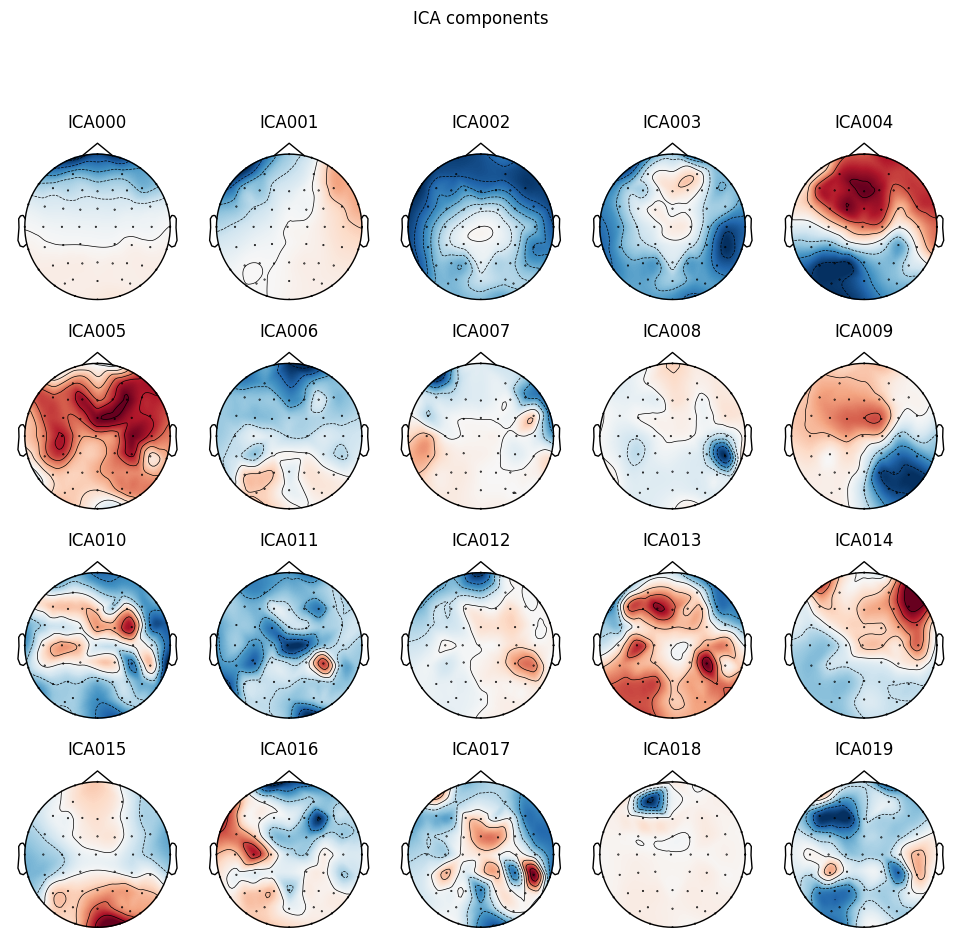

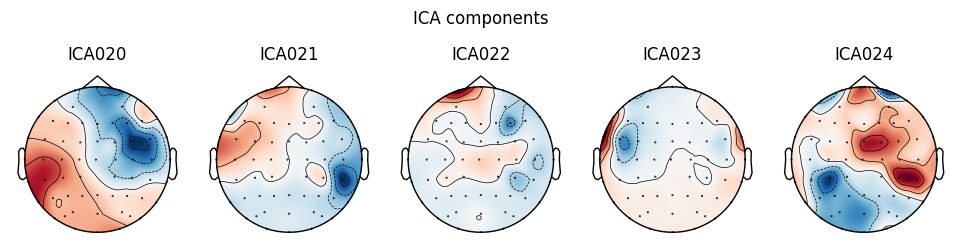

Creating RawArray with float64 data, n_channels=25, n_times=333049
    Range : 0 ... 333048 =      0.000 ...   650.484 secs
Ready.


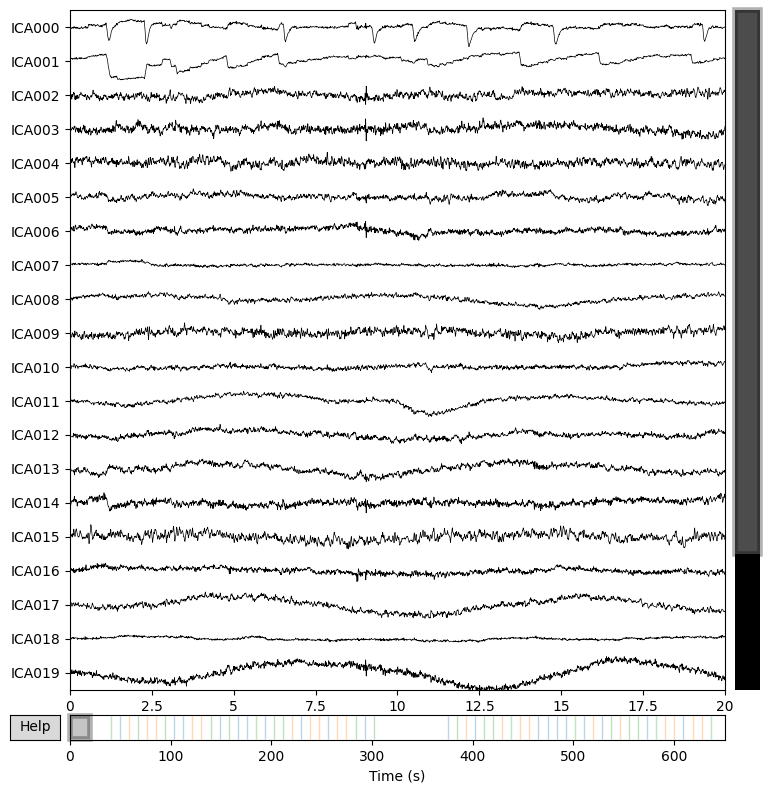

Writing ICA solution to c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm_Tactile\S29\ICA_data\sub-S29_MIpost_ica...


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:362: RuntimeWarning: This filename (Data/Group_Realistic_Arm_Tactile/S29/ICA_data/sub-S29_MIpost_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition].save(path+condition+"_ica",overwrite=True)


Subject S29: sub-S29_MIpre


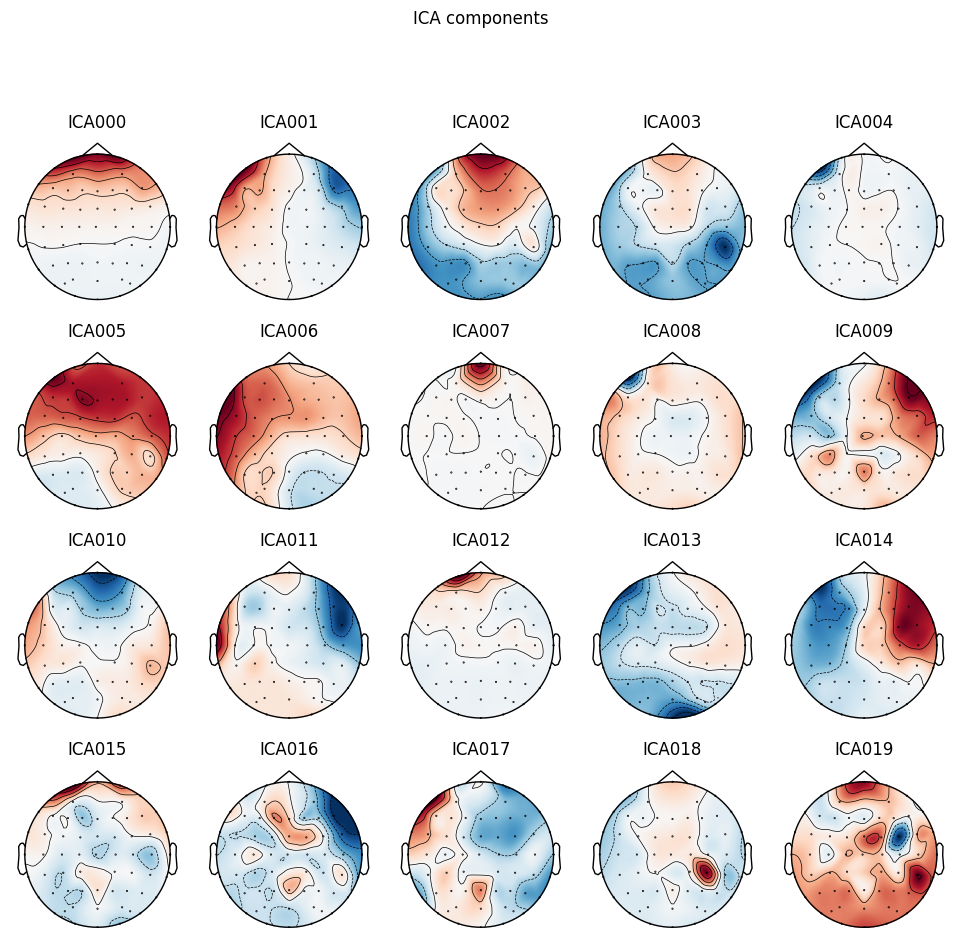

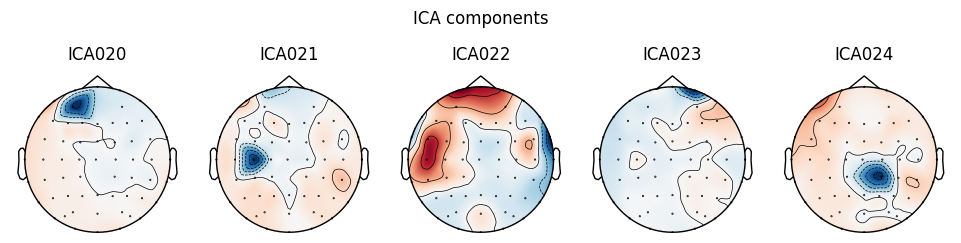

Creating RawArray with float64 data, n_channels=25, n_times=330749
    Range : 0 ... 330748 =      0.000 ...   645.992 secs
Ready.


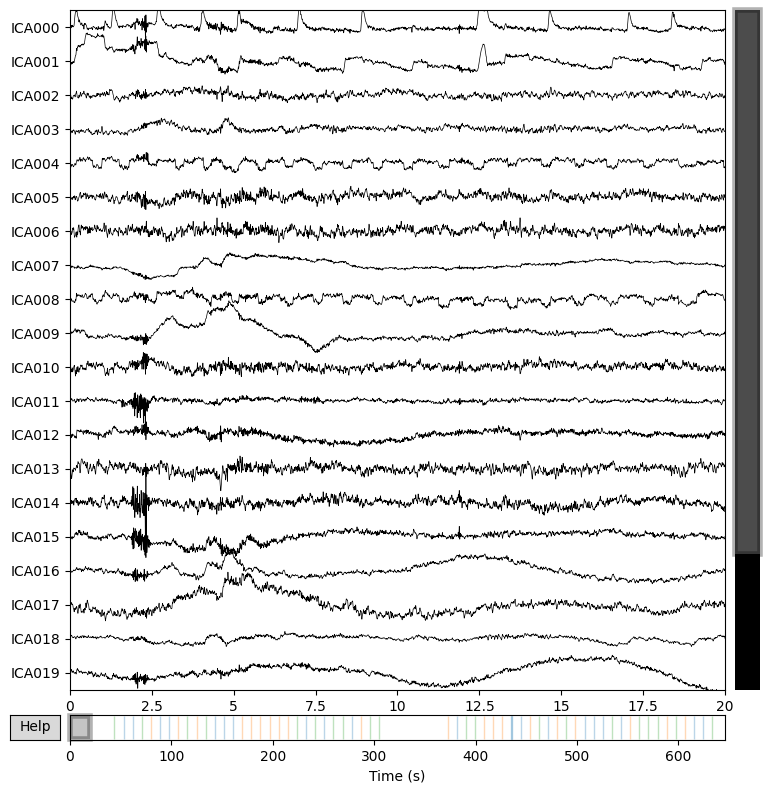

Writing ICA solution to c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm_Tactile\S29\ICA_data\sub-S29_MIpre_ica...


C:\Users\haiou\AppData\Local\Temp\ipykernel_23212\2287301412.py:362: RuntimeWarning: This filename (Data/Group_Realistic_Arm_Tactile/S29/ICA_data/sub-S29_MIpre_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition].save(path+condition+"_ica",overwrite=True)


In [12]:
IDs = np.arange(28,30)
process_all(IDs)

### ICA correction for all subjects

In [ ]:
ica_correction(np.arange(1,21))

### Miscellaneous

In [ ]:
df = pd.read_csv('Data/montage_perfect.csv')
df['ch_name'] = df['ch_name'].str.upper()
df.head()
df.to_csv('Data/montage_perfect.csv',index=False)

In [ ]:
ch_name = df.ch_name

In [ ]:
montage = get_montage(MONTAGE)
montage.plot()


In [ ]:
import pandas as pd
df = pd.read_csv('Data\subject_recap.csv')
df.head(50)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

In [ ]:
data,header = pyxdf.load_xdf('Data\S01\sub-S01_MIpre.xdf')

In [ ]:
data[2]['info']['desc'][0]['channels'][0]['channel'][0]['label'][0]

In [42]:
df = pd.read_csv('ica_recap_2.csv')
df.head(100)

condition eye_blink other
0                                       sub-S01_MIpre         0     1
1                                      sub-S01_MIpost         2     3
2                                       sub-S02_MIpre         3     6
3                                      sub-S02_MIpost       NaN   NaN
4                                       sub-S03_MIpre        14    17
5                                      sub-S03_MIpost         6    12
6                                       sub-S04_MIpre         0     5
7                                      sub-S04_MIpost         0     2
8                                       sub-S05_MIpre         1     7
9                                      sub-S05_MIpost         0     1
10                                      sub-S06_MIpre         2     7
11                                     sub-S06_MIpost         0     2
12    sub-S07_MIpre_ses-S001_task-Default_run-001_eeg         0     2
13   sub-S07_MIpost_ses-S001_task-Default_run-001_eeg         1     6
14    sub-S08_MIpre_ses-S001_task-Default_run-001_eeg         2    13
15   sub-S08_MIpost_ses-S001_task-Default_run-001_eeg         1     5
16                                      sub-S09_MIpre      4,14   NaN
17                                     sub-S09_MIpost         2   3,4
18  sub-S10_MIpost_ses-S001_task-Default_run-001_e...         0     1
19  sub-S10_MIpre_ses-S001_task-Default_run-001_ee...         0     1
20  sub-S11_MIpost_ses-S001_task-Default_run-001_e...         0     3
21  sub-S11_MIpre_ses-S001_task-Default_run-001_ee...         0     1
22  sub-S12_MIpost_ses-S001_task-Default_run-001_e...         0   NaN
23  sub-S12_MIpre_ses-S001_task-Default_run-001_ee...         1     3
24  sub-S13_MIpost_ses-S001_task-Default_run-001_e...         2     5
25  sub-S13_MIpre_ses-S001_task-Default_run-001_ee...       NaN   NaN
26  sub-S14_MIpost_ses-S001_task-Default_run-001_e...         0     1
27  sub-S14_MIpre_ses-S001_task-Default_run-001_ee...         6    19
28  sub-S15_MIpost_ses-S001_task-Default_run-001_e...         0     1
29  sub-S15_MIpre_ses-S001_task-Default_run-001_ee...         1     2
30  sub-S16_MIpost_ses-S001_task-Default_run-001_e...         3     4
31  sub-S16_MIpre_ses-S001_task-Default_run-001_ee...        16   NaN
32  sub-S17_MIpost_ses-S001_task-Default_run-001_e...         0     1
33  sub-S17_MIpre_ses-S001_task-Default_run-001_ee...         3     0
34  sub-S17_MIpre_ses-S001_task-Default_run-001_ee...       NaN   NaN
35  sub-S18_MIpost_ses-S001_task-Default_run-001_e...         0     1
36  sub-S18_MIpre_ses-S001_task-Default_run-001_ee...         0     1
37  sub-S19_MIpost_ses-S001_task-Default_run-001_e...         0     2
38  sub-S19_MIpre_ses-S001_task-Default_run-001_ee...         1     2
39                                 sub-S20_MIpost.xdf         2     6
40                                  sub-S20_MIpre.xdf         3     4

In [39]:
print(df[df['condition']=='sub-S09_MIpre']['eye_blink'].values)

['4,14']


In [10]:
folder_idxs = np.arange(10,21)
cond_list = []
for idx in folder_idxs:
    if idx < 11:
        path = 'Data/Group_Realistic_Arm/S'
        if idx < 10:
            path = path+'0'+str(idx)
        else:
            path = path+str(idx)
    else:
        path = 'Data/Group_Realistic_Arm_Tactile/S'+str(idx)
     
    initial_directory = os.getcwd()
    xdf_files = []

    for file in glob.glob(path+"\*.xdf"):
        if 'MIpre' in file or 'MIpost' in file:
            xdf_files.append(file.split('\\')[-1])
    cond_list.append(xdf_files)

In [14]:

flat_list = [item for sublist in cond_list for item in sublist]

In [20]:
array=np.empty((len(flat_list),2)) 
array.fill(np.NaN)  
print(array[:,1])

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan]


In [21]:
new_df = pd.DataFrame(
    {
        "condition":flat_list,
        "eye_blink":array[:,1],
        "other":array[:,1],
    },
)

In [22]:
new_df.head()

condition  eye_blink  other
0  sub-S10_MIpost_ses-S001_task-Default_run-001_e...        NaN    NaN
1  sub-S10_MIpre_ses-S001_task-Default_run-001_ee...        NaN    NaN
2  sub-S11_MIpost_ses-S001_task-Default_run-001_e...        NaN    NaN
3  sub-S11_MIpre_ses-S001_task-Default_run-001_ee...        NaN    NaN
4  sub-S12_MIpost_ses-S001_task-Default_run-001_e...        NaN    NaN

In [23]:
frames = [df, new_df]

result = pd.concat(frames)

In [26]:
result.to_csv('ica_recap_2',index=False)